In [1]:
# Copyright 2023 The Cirq Developers
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum utility

This colab contains code for simulating a circuit described in [1] on a subset
of qubits sufficient for reproducing the results in Fig. 4a. Running this simulation requires ~24GB of RAM, which may require a local runtime.
Additional RAM and/or compute cores can improve performance.

[1] Kim, Y., Eddins, A., Anand, S. et al. Evidence for the utility of quantum
computing before fault tolerance. Nature 618, 500–505 (2023).
https://doi.org/10.1038/s41586-023-06096-3

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

try:
    import qsimcirq
except ImportError:
    print("installing qsimcirq...")
    !pip install --quiet qsimcirq
    print(f"installed qsimcirq.")

In [3]:
import cirq
import qsimcirq
import matplotlib.pyplot as plt
import numpy as np
import sympy

In [4]:
# These 30 qubits contain the measured observable:
#
#   37-38-39-40-41-42         .   X--Y--39-Y--X--Y          .
#   |           |             .   |           |             .
#   52          53            .   X          53             .
#   |           |             .   |           |             .
#   56-57-58-59-60-61-62-63   .   X--57-X--59-60-61-X--Y    .
#         |           |       .         |           |       .
#         71          72      .         71          Y       .
#         |           |       .         |           |       .
#   75-76-77-78-79-80-81      .   Z--76-77-78-X--Y--81      .
#   |           |             .   |           |             .
#   90          91            .   Y           Y             .
#   |           |             .   |           |             .
#   94-95       98            .   94-95       98            .
#
qubit_ids = [
    *range(37, 43),  # row 0
    *range(52, 54),  # row 1
    *range(56, 64),  # row 2
    *range(71, 73),  # row 3
    *range(75, 82),  # row 4
    *range(90, 92),  # row 5
    94, 95, 98,      # row 6
]
q = {i: cirq.NamedQubit(f'q{i}') for i in qubit_ids}
qubits = list(q.values())

# This parameter will be used to sweep over X rotation angles.
theta = sympy.Symbol('theta')
x_rotations = cirq.Moment(cirq.rx(theta).on_each(qubits))

# This is the ZZ(-pi/2) gate described in equation (2).
zz_pi_2 = cirq.ZZ ** -0.5

# Each of these moments performs ZZ interactions along
# 1/3 of the edges in the region, corresponding to the
# red, blue, and green edges in Fig. 1b.
zz_layer_1 = cirq.Moment(
    zz_pi_2(q[37], q[52]),
    zz_pi_2(q[41], q[53]),
    zz_pi_2(q[56], q[57]),
    zz_pi_2(q[58], q[71]),
    zz_pi_2(q[59], q[60]),
    zz_pi_2(q[61], q[62]),
    zz_pi_2(q[72], q[81]),
    zz_pi_2(q[76], q[77]),
    zz_pi_2(q[78], q[79]),
    zz_pi_2(q[94], q[95]),
)
zz_layer_2 = cirq.Moment(
    zz_pi_2(q[38], q[39]),
    zz_pi_2(q[40], q[41]),
    zz_pi_2(q[53], q[60]),
    zz_pi_2(q[57], q[58]),
    zz_pi_2(q[62], q[63]),
    zz_pi_2(q[71], q[77]),
    zz_pi_2(q[75], q[76]),
    zz_pi_2(q[79], q[80]),
    zz_pi_2(q[90], q[94]),
    zz_pi_2(q[91], q[98]),
)
zz_layer_3 = cirq.Moment(
    zz_pi_2(q[37], q[38]),
    zz_pi_2(q[39], q[40]),
    zz_pi_2(q[41], q[42]),
    zz_pi_2(q[52], q[56]),
    zz_pi_2(q[58], q[59]),
    zz_pi_2(q[60], q[61]),
    zz_pi_2(q[62], q[72]),
    zz_pi_2(q[75], q[90]),
    zz_pi_2(q[77], q[78]),
    zz_pi_2(q[79], q[91]),
    zz_pi_2(q[80], q[81]),
)

# This circuit encapsulates a single "step", as shown
# in Fig. 1a.
step = cirq.FrozenCircuit(
    x_rotations,
    zz_layer_1,
    zz_layer_2,
    zz_layer_3,
)
# Uncomment this line to print the circuit diagram for
# a single step of the circuit.
# print(step)

In [5]:
# The circuit used to generate Fig. 4a consists of 5 steps + final rotations.
# Changing "repetitions" here will adjust the number of steps simulated.
all_steps = cirq.CircuitOperation(step, repetitions=5)
circuit = cirq.Circuit(all_steps, x_rotations)

# These are the component parts of the observable used in Fig. 4a.
x_obs = cirq.DensePauliString('X' * 8).on(*(q[i] for i in [37, 41, 52, 56, 57, 58, 62, 79]))
y_obs = cirq.DensePauliString('Y' * 8).on(*(q[i] for i in [38, 40, 42, 63, 72, 80, 90, 91]))
z_obs = cirq.DensePauliString('Z').on(q[75])
observables = [x_obs * y_obs * z_obs]

# These are approximately the values of theta plotted for experimental values
# in Fig. 4a. Changing this list will adjust the simulation to test other
# theta values.
theta_values = [0, 0.25, 0.5, 1, *np.linspace(1.2, 1.5, 7), np.pi / 2]
params = cirq.Points(key="theta", points=theta_values)

# These options are used to tune qsim performance.
# On CPU, "cpu_threads" should be set to the number of cores available.
opt = qsimcirq.QSimOptions(max_fused_gate_size=4, cpu_threads=24)
# To use GPU instead, uncomment this line:
# opt = qsimcirq.QSimOptions(use_gpu=True, gpu_mode=1)
simulator = qsimcirq.QSimSimulator(qsim_options=opt)

In [6]:
%%time
# This will log after each value of theta is simulated. Its purpose is to
# give an indication of total runtime before all simulations finish.
results = []
for i, result in enumerate(simulator.simulate_expectation_values_sweep_iter(circuit, observables, params)):
    results.append(result)
    print(f"Completed theta={theta_values[i]:.3f}; value={result}")

# Runtimes logged in the output of this cell were achieved using a machine with
# 24 cores and 80GB of RAM.

Completed theta=0.000; value=[0j]
Completed theta=0.250; value=[(4.377516467318132e-10-3.8454568700662104e-17j)]
Completed theta=0.500; value=[(-5.663425648032262e-07-6.273358064614394e-15j)]
Completed theta=1.000; value=[(-0.002025490629580058-1.285792463169913e-12j)]
Completed theta=1.200; value=[(-0.08619230321475829-4.390203478532584e-13j)]
Completed theta=1.250; value=[(-0.16428450008848153-1.3782378016635732e-15j)]
Completed theta=1.300; value=[(-0.28045473459690645-6.927717947913248e-13j)]
Completed theta=1.350; value=[(-0.43263143032440227+2.2862267634593536e-13j)]
Completed theta=1.400; value=[(-0.6074061541964849+7.668017696499385e-13j)]
Completed theta=1.450; value=[(-0.7798960015332366-1.6847268480453537e-12j)]
Completed theta=1.500; value=[(-0.9182744564246872+4.436968438601037e-13j)]
Completed theta=1.571; value=[(-0.9999907156716326-4.9043406579730134e-17j)]
CPU times: user 2h 3min 1s, sys: 4min, total: 2h 7min 2s
Wall time: 6min 8s


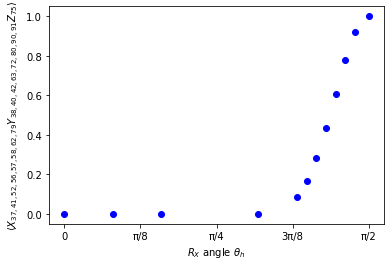

In [7]:
# Each element of "results" is a list of one expectation value.
# For visual simplicity, the results are negated.
plot_results = [-x[0].real for x in results]

# Plot the results in the format of Fig. 4a.
plt.plot(np.array(theta_values), plot_results, 'bo')
plt.xlabel(r"$ R_X $ angle $ \theta_h $")
plt.ylabel(r"$ \langle X_{37,41,52,56,57,58,62,79} Y_{38,40,42,63,72,80,90,91} Z_{75} \rangle $")
plt.xticks(np.linspace(0, np.pi / 2, 5), ["0", "π/8", "π/4", "3π/8", "π/2"])
plt.yticks(np.linspace(0, 1, 6))
plt.show()